In [23]:
# import os, cv2
# import numpy as np
# import pandas as pd
# import random, tqdm
# import seaborn as sns
# import matplotlib.pyplot as plt
# %matplotlib inline

# import warnings
# warnings.filterwarnings("ignore")

# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader
# import albumentations as album
# import segmentation_models_pytorch as smp
# from segmentation_models_pytorch.losses import DiceLoss
# import torchmetrics
# from segmentation_models_pytorch import utils
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

In [24]:
import torch
torch.cuda.is_available()
torch.cuda.device_count()
torch.cuda.current_device()
torch.cuda.device(0)
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3050 Laptop GPU'

In [25]:
!pip install -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils

The system cannot find the path specified.


## Read Data & Create train / valid splits 📁

In [26]:
DATA_DIR = "./data"

# Memuat metadata untuk data training dan validasi
train_metadata_df = pd.read_csv(os.path.join(DATA_DIR, "train_metadata_patches256.csv"))
valid_metadata_df = pd.read_csv(os.path.join(DATA_DIR, "valid_metadata_patches256.csv"))

# Pastikan bahwa kolom 'sat_image_path' dan 'mask_path' mengarah ke lokasi yang benar
train_metadata_df["sat_image_path"] = train_metadata_df["sat_image_path"].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
train_metadata_df["mask_path"] = train_metadata_df["mask_path"].apply(lambda mask_pth: os.path.join(DATA_DIR, mask_pth))

valid_metadata_df["sat_image_path"] = valid_metadata_df["sat_image_path"].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
valid_metadata_df["mask_path"] = valid_metadata_df["mask_path"].apply(lambda mask_pth: os.path.join(DATA_DIR, mask_pth))

len(train_metadata_df), len(valid_metadata_df)

(55566, 4704)

In [27]:
class_dict = pd.read_csv(os.path.join(DATA_DIR, 'class_dict.csv'))
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['built-up', 'farmland', 'forest', 'meadow', 'water', 'unknown']
Class RGB values:  [[255, 0, 0], [0, 255, 0], [0, 255, 255], [255, 255, 0], [0, 0, 255], [0, 0, 0]]


## Shortlist specific classes to segment


In [28]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['built-up', 'farmland', 'forest', 'meadow', 'water', 'unknown']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['built-up', 'farmland', 'forest', 'meadow', 'water', 'unknown']
Class RGB values:  [[255, 0, 0], [0, 255, 0], [0, 255, 255], [255, 255, 0], [0, 0, 255], [0, 0, 0]]


## Helper functions for viz. & one-hot encoding/decoding

In [29]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [30]:
class LandCoverDataset(torch.utils.data.Dataset):

    """DeepGlobe Land Cover Classification Challenge Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        df (str): DataFrame containing images / labels paths
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    def __init__(
            self, 
            df,
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.image_paths = df['sat_image_path'].tolist()
        self.mask_paths = df['mask_path'].tolist()
        
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)

## Visualize Sample Image and Mask 📈

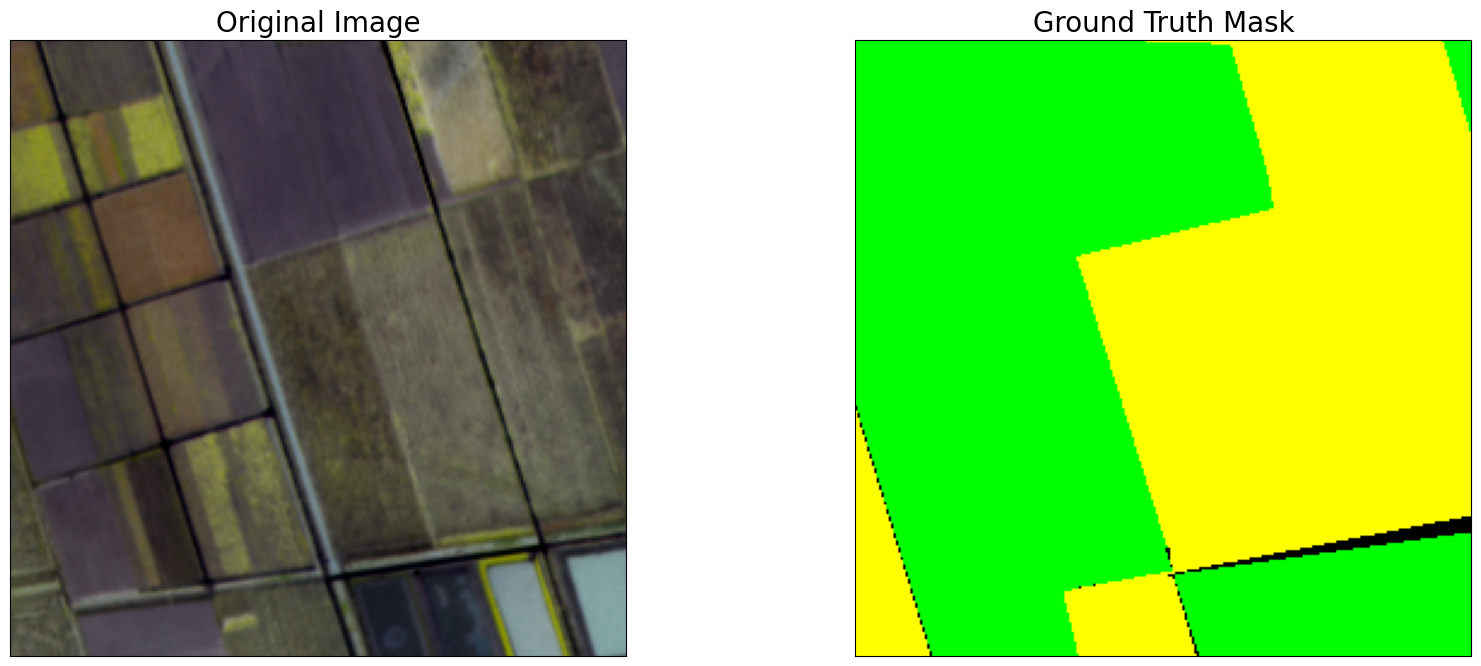

In [31]:
# Menggunakan train_metadata_df sebagai pengganti train_df
dataset = LandCoverDataset(train_metadata_df, class_rgb_values=select_class_rgb_values)

# Contoh penggunaan dataset untuk mendapatkan gambar dan mask secara acak
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[random_idx]  # Memperbaiki indeks dari 2 menjadi random_idx untuk konsistensi

# Visualisasi gambar dan mask (jika Anda memiliki fungsi visualize terdefinisi)
visualize(
    original_image=image, 
    ground_truth_mask=colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values)
)


## Defining Augmentations 


In [32]:
def get_training_augmentation():
    train_transform = [
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.HorizontalFlip(p=0.5),
        album.VerticalFlip(p=0.5),
    ]
    return album.Compose(train_transform)



def get_validation_augmentation():
    train_transform = [
        album.CenterCrop(height=256, width=256, always_apply=True),
    ]
    return album.Compose(train_transform)



def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
        
    return album.Compose(_transform)

# def get_training_augmentation():
#     train_transform = [
#         album.RandomCrop(height=1024, width=1024, always_apply=True),
#         album.HorizontalFlip(p=0.5),
#         album.VerticalFlip(p=0.5),
#     ]
#     return album.Compose(train_transform)


# def get_validation_augmentation():
#     train_transform = [
#         album.CenterCrop(height=1024, width=1024, always_apply=True),
#     ]
#     return album.Compose(train_transform)


# def to_tensor(x, **kwargs):
#     return x.transpose(2, 0, 1).astype('float32')


# def get_preprocessing(preprocessing_fn=None):
#     """Construct preprocessing transform    
#     Args:
#         preprocessing_fn (callable): data normalization function 
#             (can be specific for each pretrained neural network)
#     Return:
#         transform: albumentations.Compose
#     """
#     _transform = []
#     if preprocessing_fn:
#         _transform.append(album.Lambda(image=preprocessing_fn))
#     _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
#     return album.Compose(_transform)

## Visualize Augmented Images & Masks

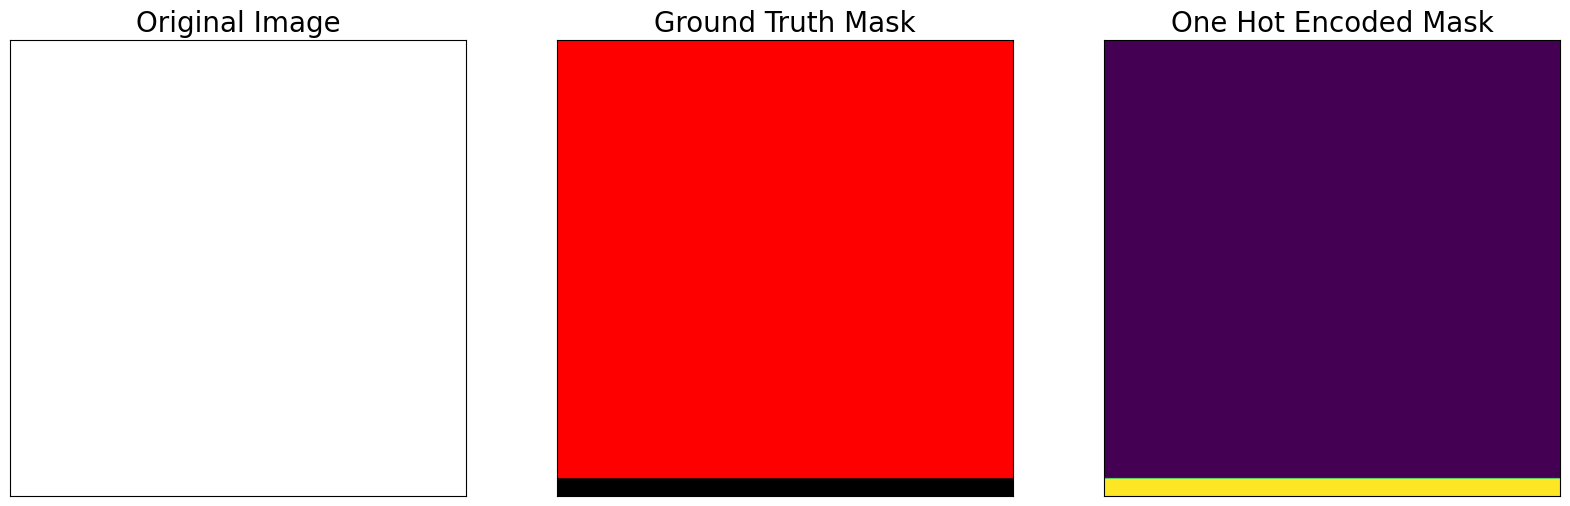

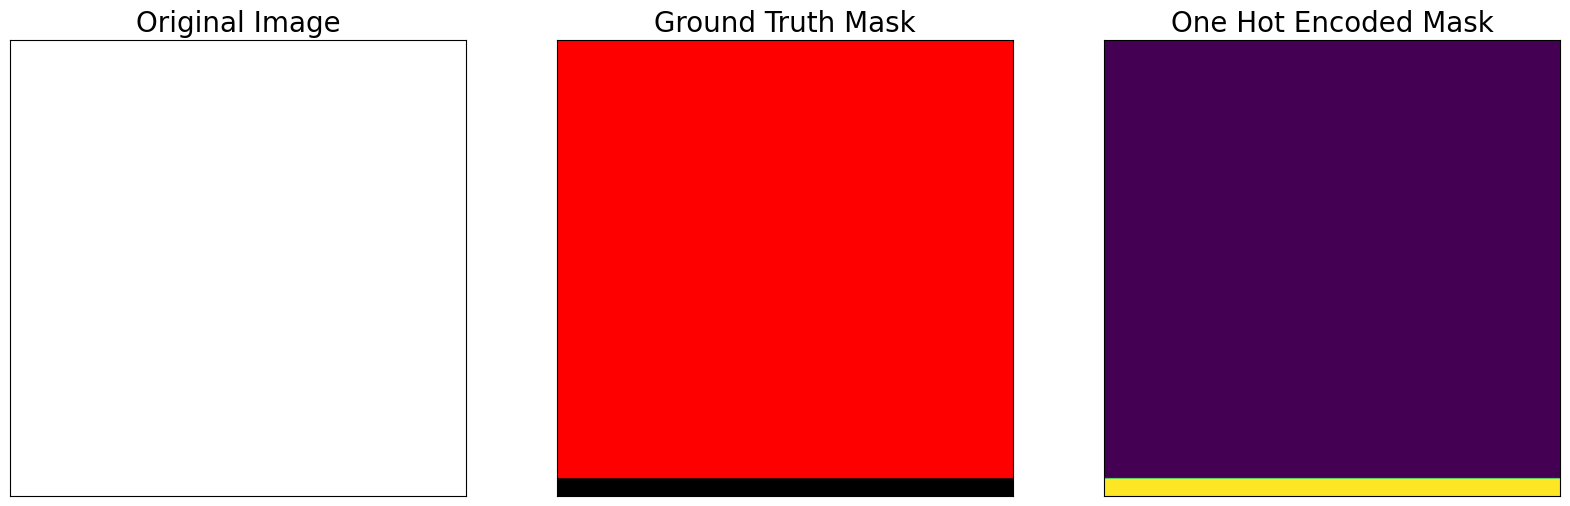

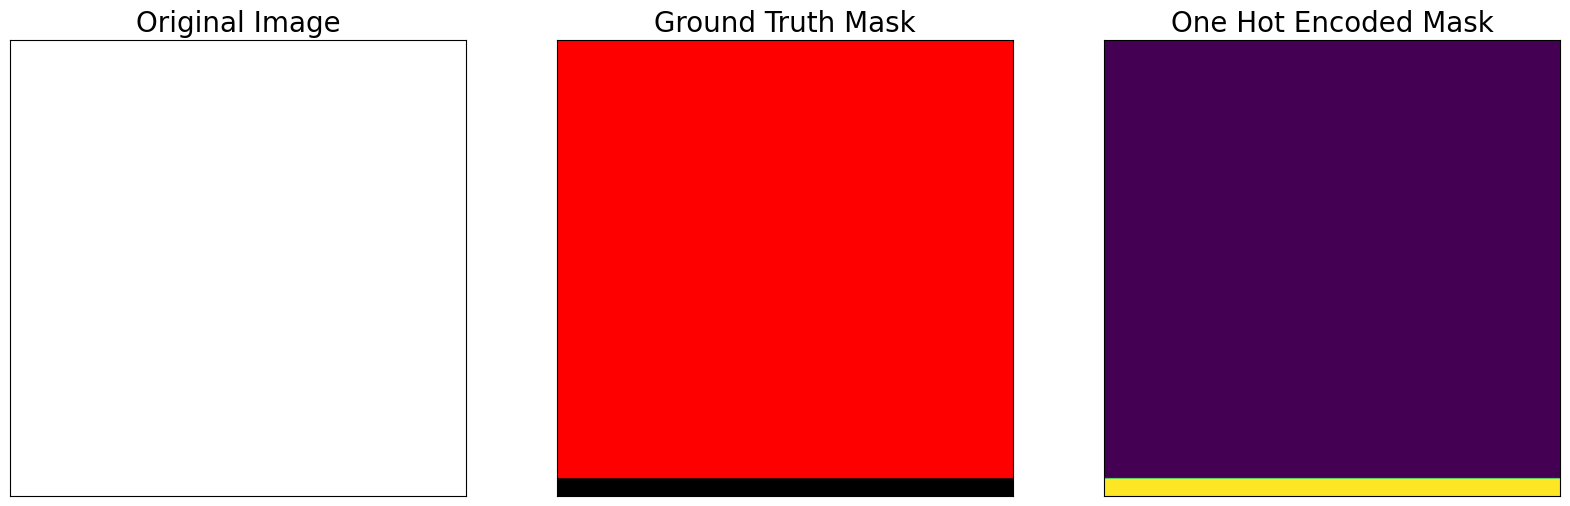

In [33]:
augmented_dataset = LandCoverDataset(
    train_metadata_df, 
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on image/mask pairs
for idx in range(3):
    image, mask = augmented_dataset[idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

## Model Definition

In [34]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

## Get Train / Val DataLoaders

In [35]:
# Get train and val dataset instances
train_dataset = LandCoverDataset(
    train_metadata_df, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = LandCoverDataset(
    valid_metadata_df, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=0    )


# # Get train and val dataset instances menggunakan DataFrame yang telah dipatch
# train_dataset = LandCoverDataset(
#     train_metadata_df, 
#     augmentation=get_training_augmentation(),
#     preprocessing=get_preprocessing(preprocessing_fn),
#     class_rgb_values=select_class_rgb_values,
# )

# valid_dataset = LandCoverDataset(
#     valid_metadata_df, 
#     augmentation=get_validation_augmentation(),
#     preprocessing=get_preprocessing(preprocessing_fn),
#     class_rgb_values=select_class_rgb_values,
# )

# # Get train and val data loaders
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
# valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)


## Set Hyperparams

In [36]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 5

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00008),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint from previous commit (if present)
if os.path.exists('../deeplabv3/best_model.pth'):
    model = torch.load('../deeplabv3/best_model.pth', map_location=DEVICE)
    print('Loaded pre-trained DeepLabV3+ model!')

In [37]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

## Training DeepLabV3+

In [38]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 294/294 [02:48<00:00,  1.75it/s, dice_loss - 0.2009, iou_score - 0.6762]
Model saved!

Epoch: 1
valid: 100%|██████████| 294/294 [02:35<00:00,  1.89it/s, dice_loss - 0.2092, iou_score - 0.6658]

Epoch: 2
valid: 100%|██████████| 294/294 [02:35<00:00,  1.90it/s, dice_loss - 0.1931, iou_score - 0.684] 
Model saved!

Epoch: 3
valid: 100%|██████████| 294/294 [02:35<00:00,  1.89it/s, dice_loss - 0.2005, iou_score - 0.6768]

Epoch: 4
valid: 100%|██████████| 294/294 [02:34<00:00,  1.90it/s, dice_loss - 0.1887, iou_score - 0.6913]
Model saved!
CPU times: total: 4h 38min 55s
Wall time: 4h 32min 34s


## Prediction on Test Data

In [39]:
# load best saved model checkpoint from the current run
if os.path.exists('./best_model.pth'):
    best_model = torch.load('./best_model.pth', map_location=DEVICE)
    print('Loaded DeepLabV3+ model from this run.')

# load best saved model checkpoint from previous commit (if present)
elif os.path.exists('../input/deepglobe-land-cover-classification-deeplabv3/best_model.pth'):
    best_model = torch.load('../input/deepglobe-land-cover-classification-deeplabv3/best_model.pth', map_location=DEVICE)
    print('Loaded DeepLabV3+ model from a previous commit.')

Loaded DeepLabV3+ model from this run.


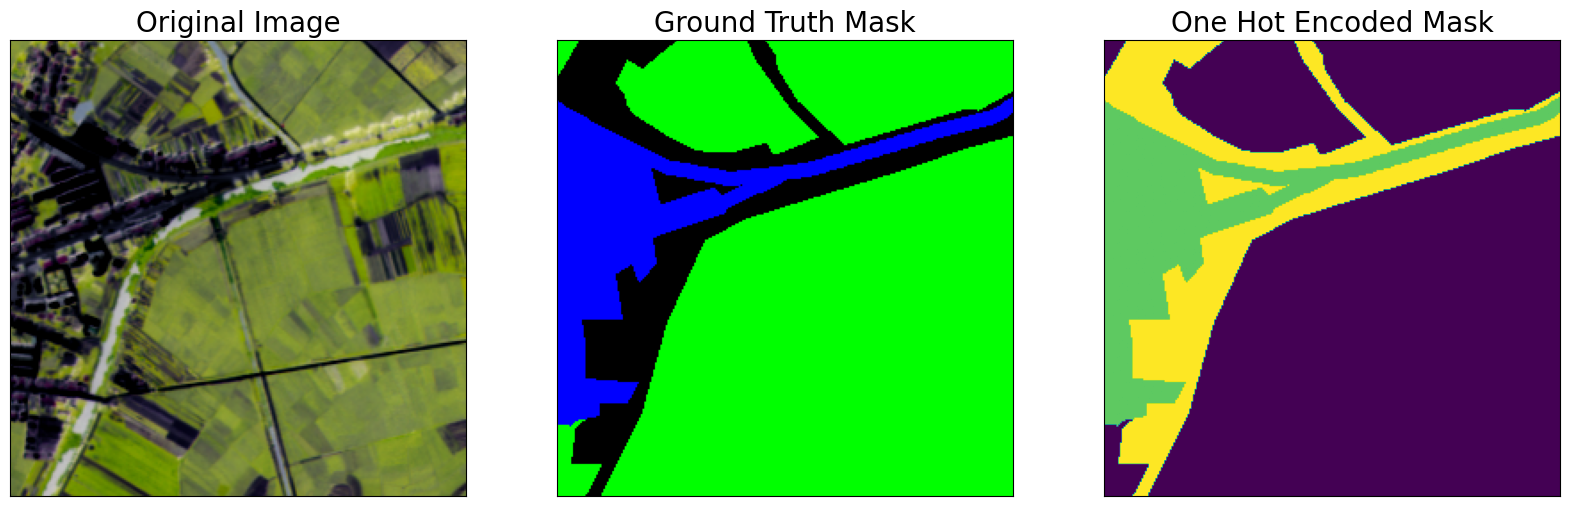

In [40]:
# create test dataloader to be used with DeepLabV3+ model (with preprocessing operation: to_tensor(...))
test_dataset = LandCoverDataset(
    valid_metadata_df, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing augmentations & transformations)
test_dataset_vis = LandCoverDataset(
    valid_metadata_df,
    augmentation=get_validation_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [41]:
# Ambil jumlah kelas dari class_names yang sudah ada
num_classes = len(class_names)

In [42]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [43]:
best_model = model

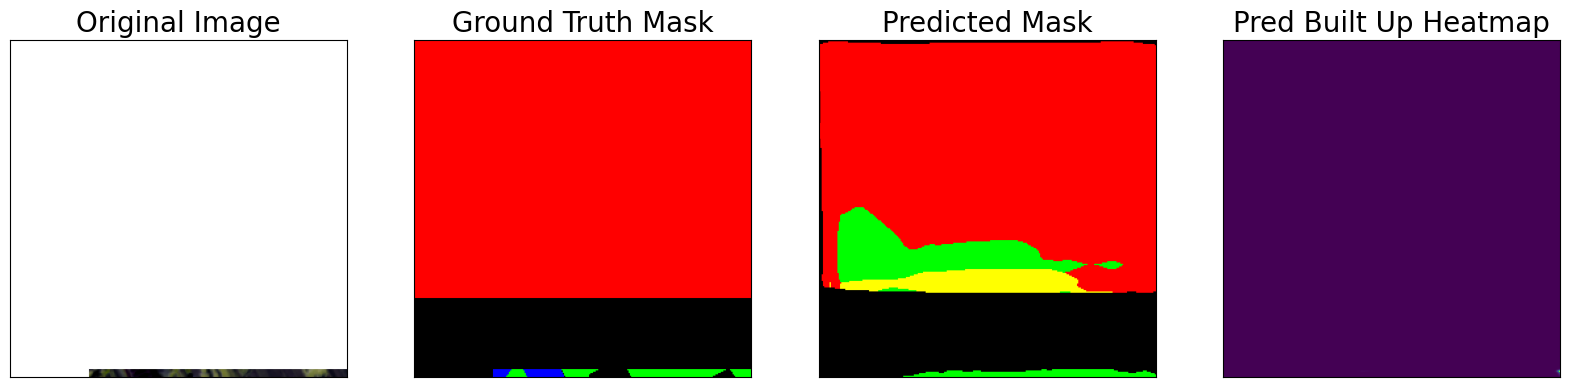

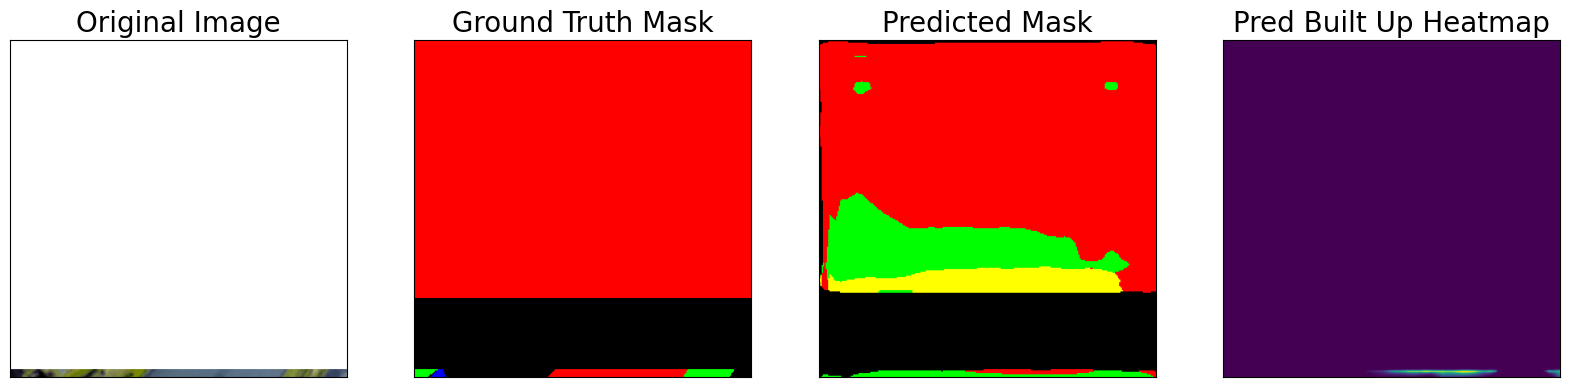

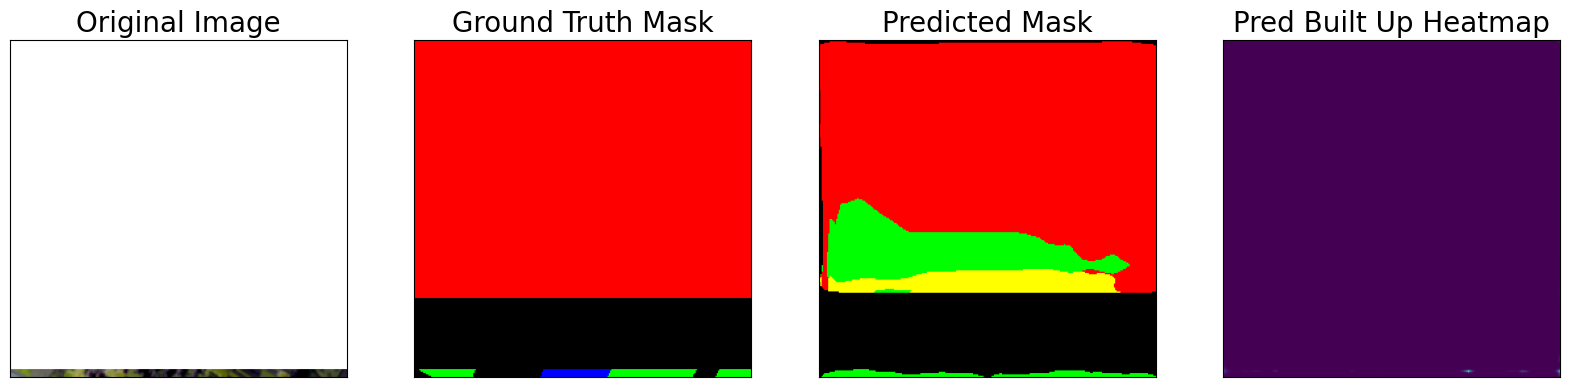

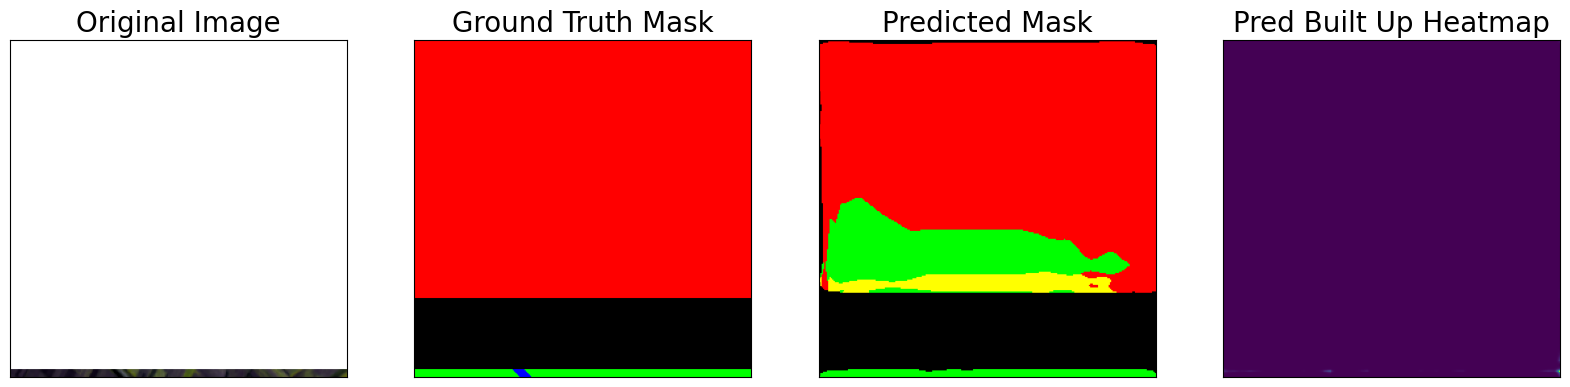

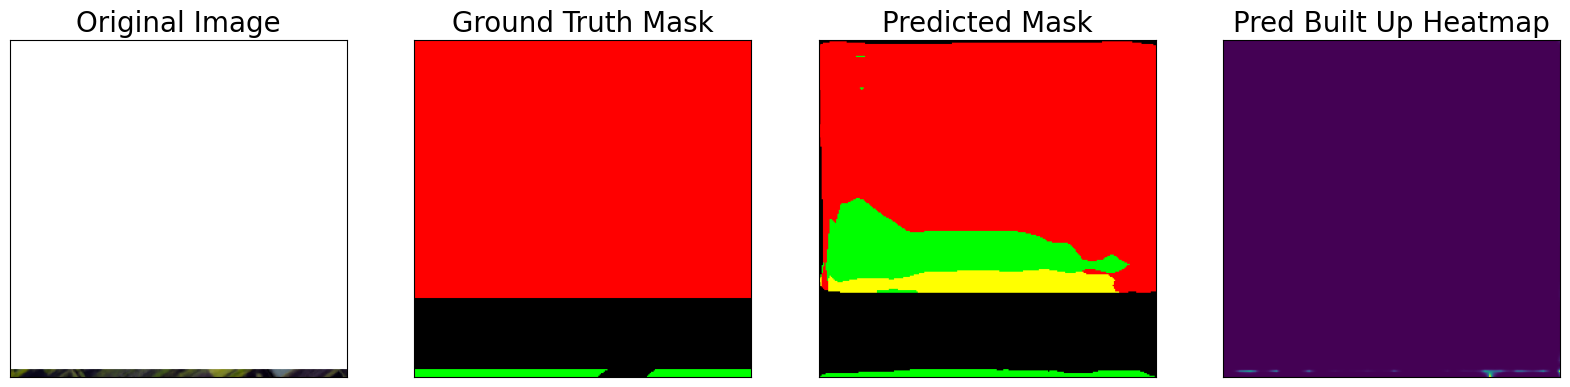

In [49]:
# for idx in range(len(test_dataset)):

#     image, gt_mask = test_dataset[idx]
#     image_vis = test_dataset_vis[idx][0].astype('uint8')
#     x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
#     # Predict test image
#     pred_mask = best_model(x_tensor)
#     pred_mask = pred_mask.detach().squeeze().cpu().numpy()
#     # Convert pred_mask from `CHW` format to `HWC` format
#     pred_mask = np.transpose(pred_mask,(1,2,0))
#     # Get prediction channel corresponding to foreground
#     pred_built_up_heatmap = pred_mask[:,:,select_classes.index('built-up')]
#     pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values)
#     # Convert gt_mask from `CHW` format to `HWC` format
#     gt_mask = np.transpose(gt_mask,(1,2,0))
#     gt_mask = colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values)
#     cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])
    
#     visualize(
#         original_image = image_vis,
#         ground_truth_mask = gt_mask,
#         predicted_mask = pred_mask,
#         pred_built_up_heatmap = pred_built_up_heatmap
#     )

# Tentukan jumlah maksimum prediksi untuk divisualisasikan
max_visualizations = 5

for idx in range(len(test_dataset)):
    if idx >= max_visualizations:
        break  # Keluar dari loop setelah mencapai batas maksimum visualisasi

    image, gt_mask = test_dataset[idx]
    image_vis = test_dataset_vis[idx][0].astype('uint8')
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to foreground
    pred_built_up_heatmap = pred_mask[:,:,select_classes.index('built-up')]
    pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values)
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values)
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])
    
    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        pred_built_up_heatmap = pred_built_up_heatmap
    )

## Model Evaluation on Test Dataset

In [45]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 4704/4704 [03:05<00:00, 25.33it/s, dice_loss - 0.1915, iou_score - 0.7117]
Evaluation on Test Data: 
Mean IoU Score: 0.7117
Mean Dice Loss: 0.1915


## Plot Dice Loss & IoU Metric for Train vs. Val

In [46]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

,0,1,2,3,4
dice_loss,0.223823,0.160392,0.147934,0.141238,0.137361
iou_score,0.674262,0.729198,0.746086,0.755676,0.761361


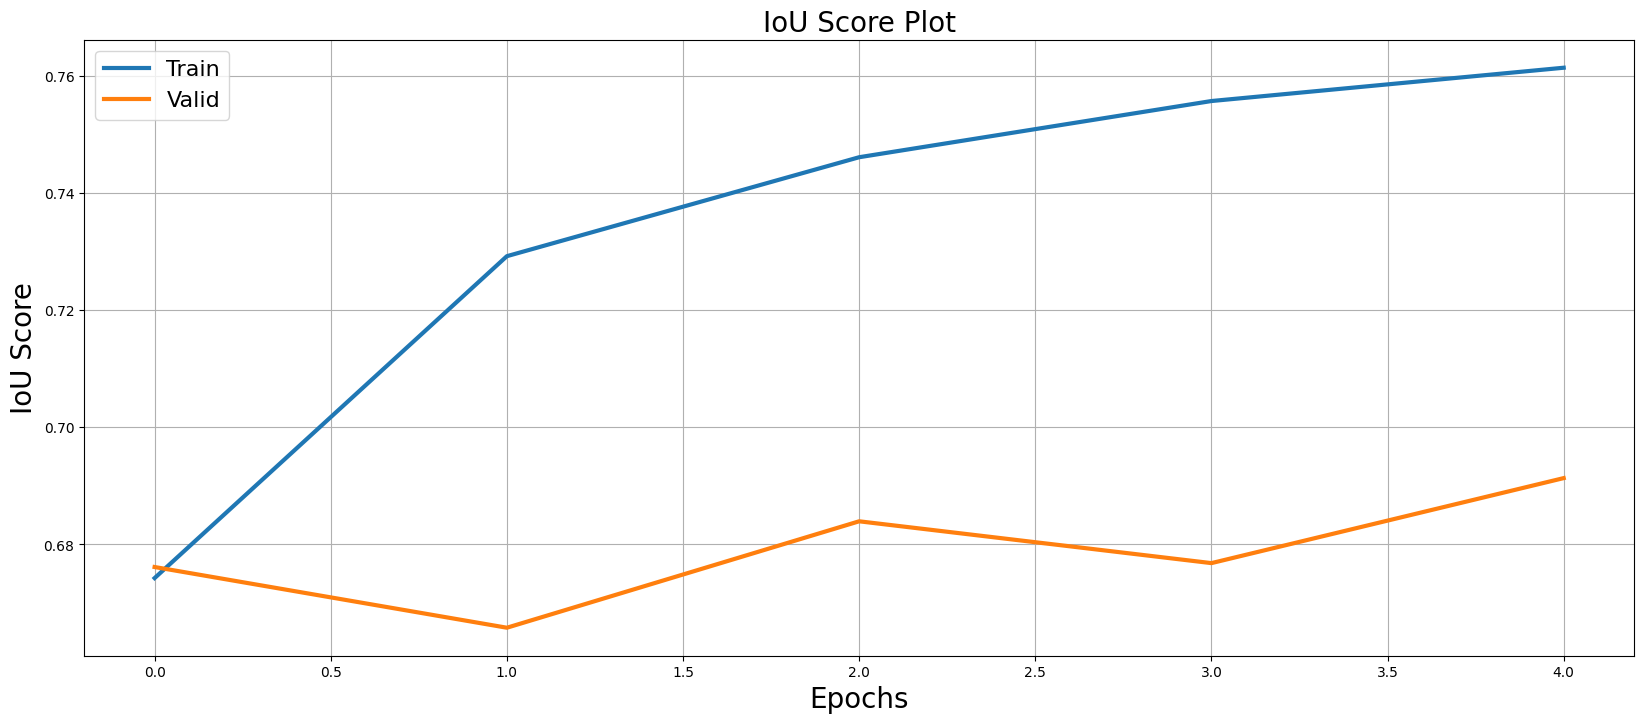

In [47]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

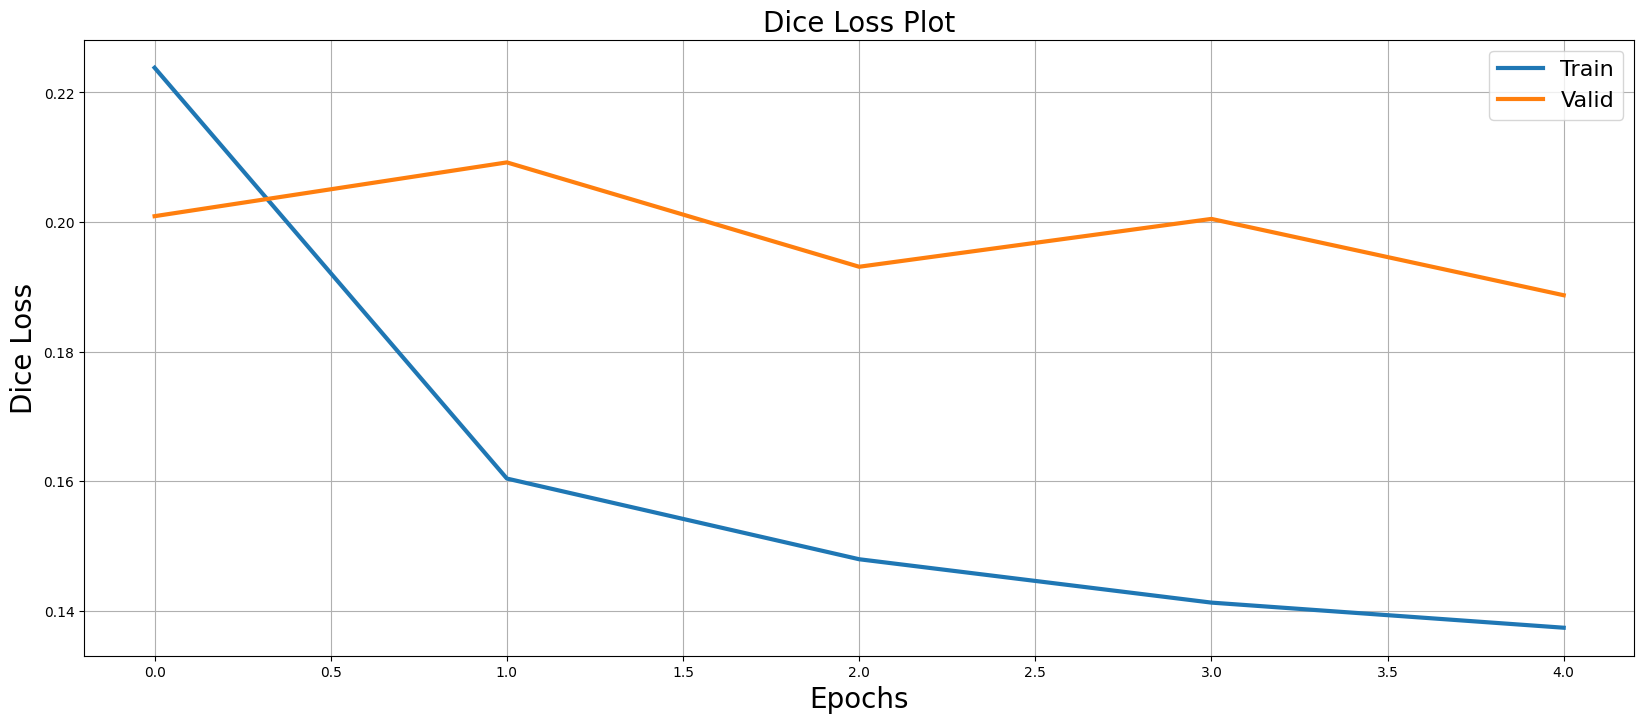

In [48]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()